In [1]:
import sys
sys.path.append('../')
from config import configuration
config = configuration()
config.request_password()

def get_lightcurve(sourceid):

    lcs = pd.DataFrame(sqlutilpy.get('''
                                select sourceid, 
                                unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as emag,
                                unnest(filterid) as filterid,
                                unnest(chi) as chi,
                                unnest(ast_res_chisq) as ast_res_chisq,
                                unnest(ambiguous_match) as ambiguous_match  
                                from leigh_smith.virac2_ts_tmolnar_train_zyjhk where sourceid={0}'''.format(sourceid),
                     **config.wsdb_kwargs))
    
    if len(lcs)==0:

        lcs = pd.DataFrame(sqlutilpy.get('''
                                    select sourceid, 
                                    unnest(mjdobs) as mjdobs,
                                    unnest(mag) as mag,
                                    unnest(emag) as emag,
                                    unnest(filterid) as filterid,
                                    unnest(chi) as chi,
                                    unnest(ast_res_chisq) as ast_res_chisq,
                                    unnest(ambiguous_match) as ambiguous_match  
                                    from leigh_smith.virac2_ts_tmolnar_variables_v2 where sourceid={0}'''.format(sourceid),
                         **config.wsdb_kwargs))
    
    return lcs


 ·············


In [2]:
def load_lc(sid, ra, dec):
    lc=get_lightcurve(sid)
    clean = (lc['filterid']==5)&(lc['ambiguous_match']==0)&(lc['ast_res_chisq']<11.829)&\
        (~((lc['chi']>5.)&(lc['mag']<13.2)))
    lc = sigclipper(lc[clean])

    correct_to_HJD(lc,
                 ra,
                 dec)
    return lc

def plot_lc_sid(sid,ra,dec,per,nterms,ax=None,reg=True,xlabel=False,right=False,offs=0,pcolor='gray',
               mcolor='#FFA500',ps='o',ttitle='',ylabel=True):
    
    lc = load_lc(sid, ra, dec)

    tt = lc['HJD'].values[np.argmin(np.abs(lc['mag'].values-np.nanpercentile(lc['mag'],98.)))]

    model = LombScargle(lc['HJD'].values-tt, lc['mag'].values, 
                        lc['emag'].values, normalization='standard')
    freq, power = model.autopower(maximum_frequency=10.)

    if xlabel:
        plt.xlabel('Phase')
    if ylabel:
        plt.ylabel(r'$K_s$ + arbitrary offset [mag] ')
#     nterms=combo_dset['lsq_nterms'].values[fltr][ii]
    opt_reg=0
    if reg:
        opt_reg=optimum_regularization(lc['mag'].values, lc['emag'].values)

    results_d = fourier_poly_chi2_fit_full(
                                             times=lc['HJD'].values-tt,
                                             mag=lc['mag'].values,
                                             err=lc['emag'].values,
                                             freq_dict={'freq_grid':np.array([1./per])},
                                             nterms=np.int64(nterms),
                                             npoly=2,
                                             regularization=opt_reg,
                                             time_zeropoint_poly=0.,
                                             regularize_by_trace = True,
                                             check_multiples=False, 
                                             use_power_of_2=False,
                                             return_period_error=False)

    xx=np.linspace(-1.1*per,3.1*per,5000)
    FF = retrieve_fourier_poly(xx,
                               results_d)
    xx0 = xx[np.argmax(FF[xx<0])]
    
    plt.errorbar((((lc['HJD'].values-tt-xx0)%(2.*per))/per),
                 lc['mag'].values-np.nanmedian(FF)+offs,
                 yerr=lc['emag'].values,fmt=ps,color=pcolor,mew=0.5,mec='k',alpha=0.5,ms=5,
                rasterized=True)
#     plt.ylim(np.nanmean(lc['mag'].values)-0.3,np.nanmean(lc['mag'].values)+0.3)
    plt.gca().invert_yaxis()
    plt.xlim(-0.1,2.1)
    # plt.ylim(-0.5,0.5)
    
    tt = plt.annotate('%0.2fd'%per,xy=(2.,offs),ha='right',va='center',zorder=100,fontsize=12)
    tt.set_bbox({'facecolor':'white', 'alpha':0.7,'edgecolor':'None','pad':1.})
    
    plt.plot((xx-xx0)/per, FF-np.nanmedian(FF)+offs,color=mcolor,lw=3,zorder=10,alpha=0.85)

    if offs==0:
        plt.ylim(np.nanmax(FF)+0.15-np.nanmedian(FF),np.nanmin(FF)-0.15-np.nanmedian(FF))
    
    if right:
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
    plt.title(ttitle,fontsize=16)
    return results_d

In [3]:
from matplotlib.ticker import LogLocator, ScalarFormatter
from fine_classif.feat_extract.compute_feats import sigclipper, correct_to_HJD, LombScargle, optimum_regularization, fourier_poly_chi2_fit_full, retrieve_fourier_poly

In [4]:
import sqlutilpy
full_data=pd.DataFrame(sqlutilpy.get("""select * from jason_sanders.virac2_variables""",
                                     **config.wsdb_kwargs))

In [5]:
import seaborn as sns
from matplotlib.colors import to_hex
to_hex(sns.color_palette('Set3')[0])

'#8dd3c7'

In [7]:
fltr = (full_data['prob']>0.9)&(full_data['class']=='RRab')\
              &(np.abs(full_data['b'])<2.)&((full_data['l']>350.)|(full_data['l']<10.))\
            &(full_data['delta_logl_lsq_const']>800.)&(full_data['lsq_period']<600.)

In [8]:
import sys
sys.path.append('../../../')
from gaussian_process import run_gp_quick, plot_lc_GP
sys.path.append('../../../../mira_project/')
sys.path.append('../../../../')
from find_analyse_variables import generate_results_gp

/data/jls/python3.5/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: Python 3.5 support will be dropped in the next release ofcryptography. Please upgrade your Python.
  from cryptography.utils import int_from_bytes


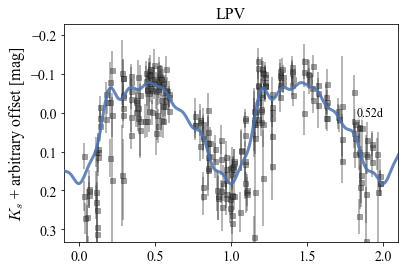

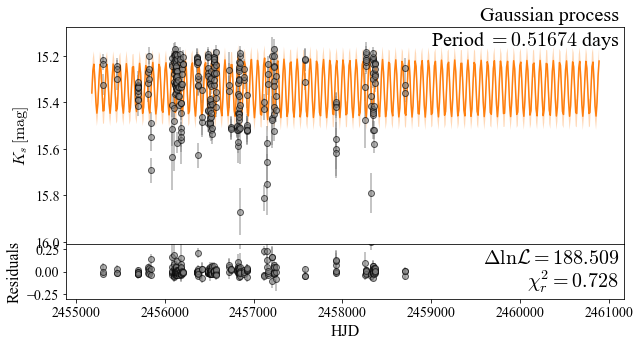

In [10]:
ii=25
jj=0
scl_factor=0.4
clss='LPV'
axii=0
plot_lc_sid(full_data[fltr]['sourceid'].values[ii],
                    full_data[fltr]['ra'].values[ii],
                    full_data[fltr]['dec'].values[ii],
                    full_data[fltr]['period'].values[ii],
                    full_data[fltr]['lsq_nterms'].values[ii],
                    offs=jj*scl_factor,
                   mcolor='#FFA500'*(jj%2)+'#4c72b0'*((jj+1)%2),
                   pcolor='gray'*(jj%2)+'#404040'*((jj+1)%2),
                   ps='o'*(jj%2)+'s'*((jj+1)%2),ttitle=clss,ylabel=(axii==0));
LC = load_lc(full_data[fltr]['sourceid'].values[ii],
                    full_data[fltr]['ra'].values[ii],
                    full_data[fltr]['dec'].values[ii])
LC['error']=LC['emag']
gpp=run_gp_quick(LC,per_guess=full_data[fltr]['period'].values[ii])
# gpp,gpprops, lcprops, dll, dllG, rchi, delta_aic, delta_bic=\
#             generate_results_gp(LC,[period_fix(full_data)[fltr][ii]])
plot_lc_GP(LC,gpp);

8303
0.5132919023089096
0.4875025960635666
0.5808571965760058
0.5595238697594792
0.5861747611521998
0.5952214813240742
0.4792991520323473
0.6039975454684721
56
0.3917072391363001
0.3689494161247578
0.4298867065128713
0.31095863174642163
0.3224978919550937
0.3213187052810021
0.29228572879992665
0.32051108481875323
21765
4.644662603231807
1.3151735755356428
1.4941527009189066
0.6199421440869775
0.7776686355587571
0.8204508582919592
17.7399086780247
0.6969148900392227
2638
0.37479741434986
0.5010885990225784
0.5311430622617552
0.4270590513460851
0.4652075609862354
0.5745589887086423
0.4266341593924074
0.5242911434100804
2570
151.62384558791598
5.375034005975503
19.2312204298343
3.862347136536107
11.211816891651834
26.31238843640296
57.75176646350371
19.370000463046857
222
9.091820074165684
4.192163672879808
13.125209886016991
6.52799976669206
5.585470205102046
2.9606950203795463
10.667892205512686
11.580311044371829
1061
8.376069800897133
7.018044128254008
1.7776062800210208
12.2924140817

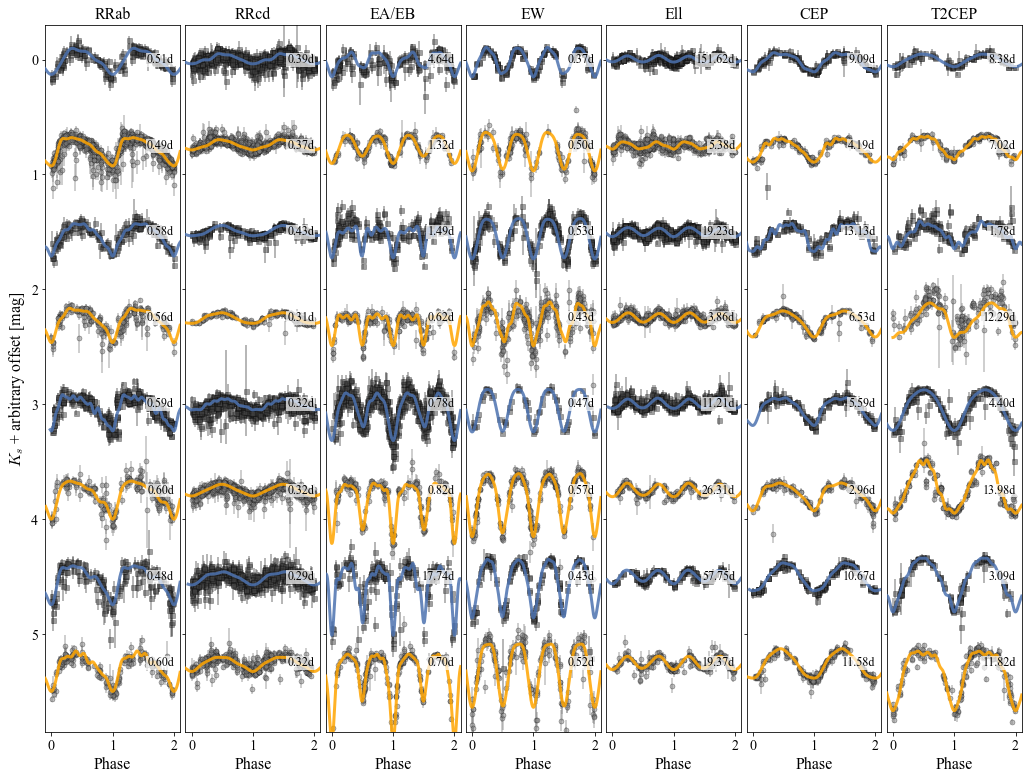

In [15]:
clss='RRab'

Ncol=7
fig,ax=plt.subplots(1,Ncol,figsize=[2.5*Ncol,13.],sharey=True)
plt.subplots_adjust(wspace=0.04,hspace=0.)

for axii, clss in enumerate(['RRab','RRcd','EA/EB','EW','Ell','CEP','T2CEP']):
    plt.sca(ax[axii])
    fltr = (full_data['prob']>0.9)&(full_data['class']==clss)\
              &(np.abs(full_data['b'])<2.)&((full_data['l']>350.)|(full_data['l']<10.))\
            &(full_data['delta_logl_lsq_const']>300.)

    print(np.count_nonzero(fltr))
    np.random.seed(42)
    selection = np.random.choice(np.arange(np.count_nonzero(fltr)),np.min([np.count_nonzero(fltr),8]),replace=False)
    selection = selection[np.argsort(full_data['ks_lsq_amplitude'].values[fltr][selection])]

    # plt.sca(a[0])
    scl_factor=0.75
    for jj, ii in enumerate(selection):
        print(full_data[fltr]['period'].values[ii])
    #     plt.sca(a[jj])
        plot_lc_sid(full_data[fltr]['sourceid'].values[ii],
                    full_data[fltr]['ra'].values[ii],
                    full_data[fltr]['dec'].values[ii],
                    full_data[fltr]['period'].values[ii],
                    full_data[fltr]['lsq_nterms'].values[ii],
                    offs=jj*scl_factor,
                   mcolor='#FFA500'*(jj%2)+'#4c72b0'*((jj+1)%2),
                   pcolor='gray'*(jj%2)+'#404040'*((jj+1)%2),
                   ps='o'*(jj%2)+'s'*((jj+1)%2),ttitle=clss,ylabel=(axii==0));
    plt.ylim(-scl_factor*0.4,(len(selection)-1)*scl_factor+scl_factor*0.8)
    # plt.sca(a[-2]);plt.xlabel('Phase')
    # plt.sca(a[-1]);plt.xlabel('Phase')
    plt.xlabel('Phase')
    plt.gca().invert_yaxis()
plt.savefig('lc_gallery.pdf',bbox_inches='tight')

In [63]:
!ls -lt lc_gallery.pdf

-rw-r--r-- 1 jls jls 748297 May 19 12:02 lc_gallery.pdf
